In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random, os
import numpy as np
import torch
import importlib
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE.single import objVAE_single
from objVAE.single import bg_single
from objVAE.single import utils_single

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

2024-02-04 14:42:17.361587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 14:42:18.628999: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

In [2]:
def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        alpha = z_pres.detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[alpha]
        edge_color = plt.cm.get_cmap('spring')(z_pres[alpha].detach().cpu().numpy())

    else:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        xy = xy.detach().cpu().numpy()[:]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 3)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], s=10, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    plt.subplot(2, 2, 1)
    plt.imshow(
        background[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("background")

    plt.subplot(2, 2, 2)
    plt.imshow(
        x_hat[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("forground")

    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

torch.Size([400, 1, 256, 256])


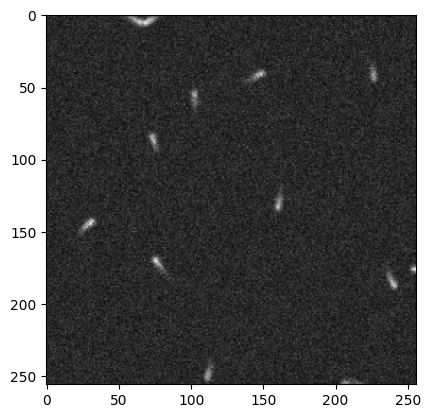

In [3]:
import tifffile
from glob import glob

x_crop = 256
y_crop = 256

paths = r'/data/mp_mpa/microtubule-sn7-low/*.tif'
paths = sorted(glob(paths))

images = [
    tifffile.imread(path) for path in paths
]
 
images = np.array(images)

images_array = []
for i in range(images.shape[1] // x_crop):
    for j in range(images.shape[2] // y_crop):
        images_array.append(images[:, (i)*x_crop:(i+1)*x_crop, (j)*y_crop:(j+1)*y_crop])


images = np.concatenate(images_array, axis=0)

training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(0, 1, 2), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=1)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[8,:,:,:]), cmap='gray')


In [4]:
train, test = torch.utils.data.random_split(training_images, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [10]:
import IPython.display as ipd

# Callbacks
max_steps = 20000
beta_annealing_end = 1800
lr_annealing_end = max_steps
kl_annealing_end = 2400 # 2400
presence_annealing_end = 1000

def beta_annealing(step):
    """
    logs = np.logspace(-8, -2.5, beta_annealing_end) # 8.3 - 7
    if step < beta_annealing_end:
        return logs[int(step)]
    else:
        return logs[-1]
    """
    return 0
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < 500:
        return 0
    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1

def presence_annealing(step):
    lins = np.linspace(0.1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 10:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [11]:
importlib.reload(objVAE_single)
importlib.reload(bg_single)

load_model = ""

#load_model = "../state_dicts/model-musc-bg.pth"
#load_model = "../state_dicts/model-microtubuler-256px-bad.pth"


num_entities = 25
latent_dim = 10
beta = 1e-4
object_radius = 16
combine_method = "sum"
topk_select_method = 'max'
decoder="linnear"
decoder_feature_size=56 #56
encoder_num_layers= 4
decoder_num_layers=8

single_decoder = True

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 5,
    'hidden_dim': 12,
    'position_dim': 128
}

background_model = bg_single.objBG(in_channels=1,image_size=256, **bg_params)

model = objVAE_single.MEVAE(
    num_entities,
    background_model=background_model,
    beta=beta,
    latent_dim=latent_dim,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_num_layers=encoder_num_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))


In [21]:
for param in model.model.parameters():
    param.requires_grad = True

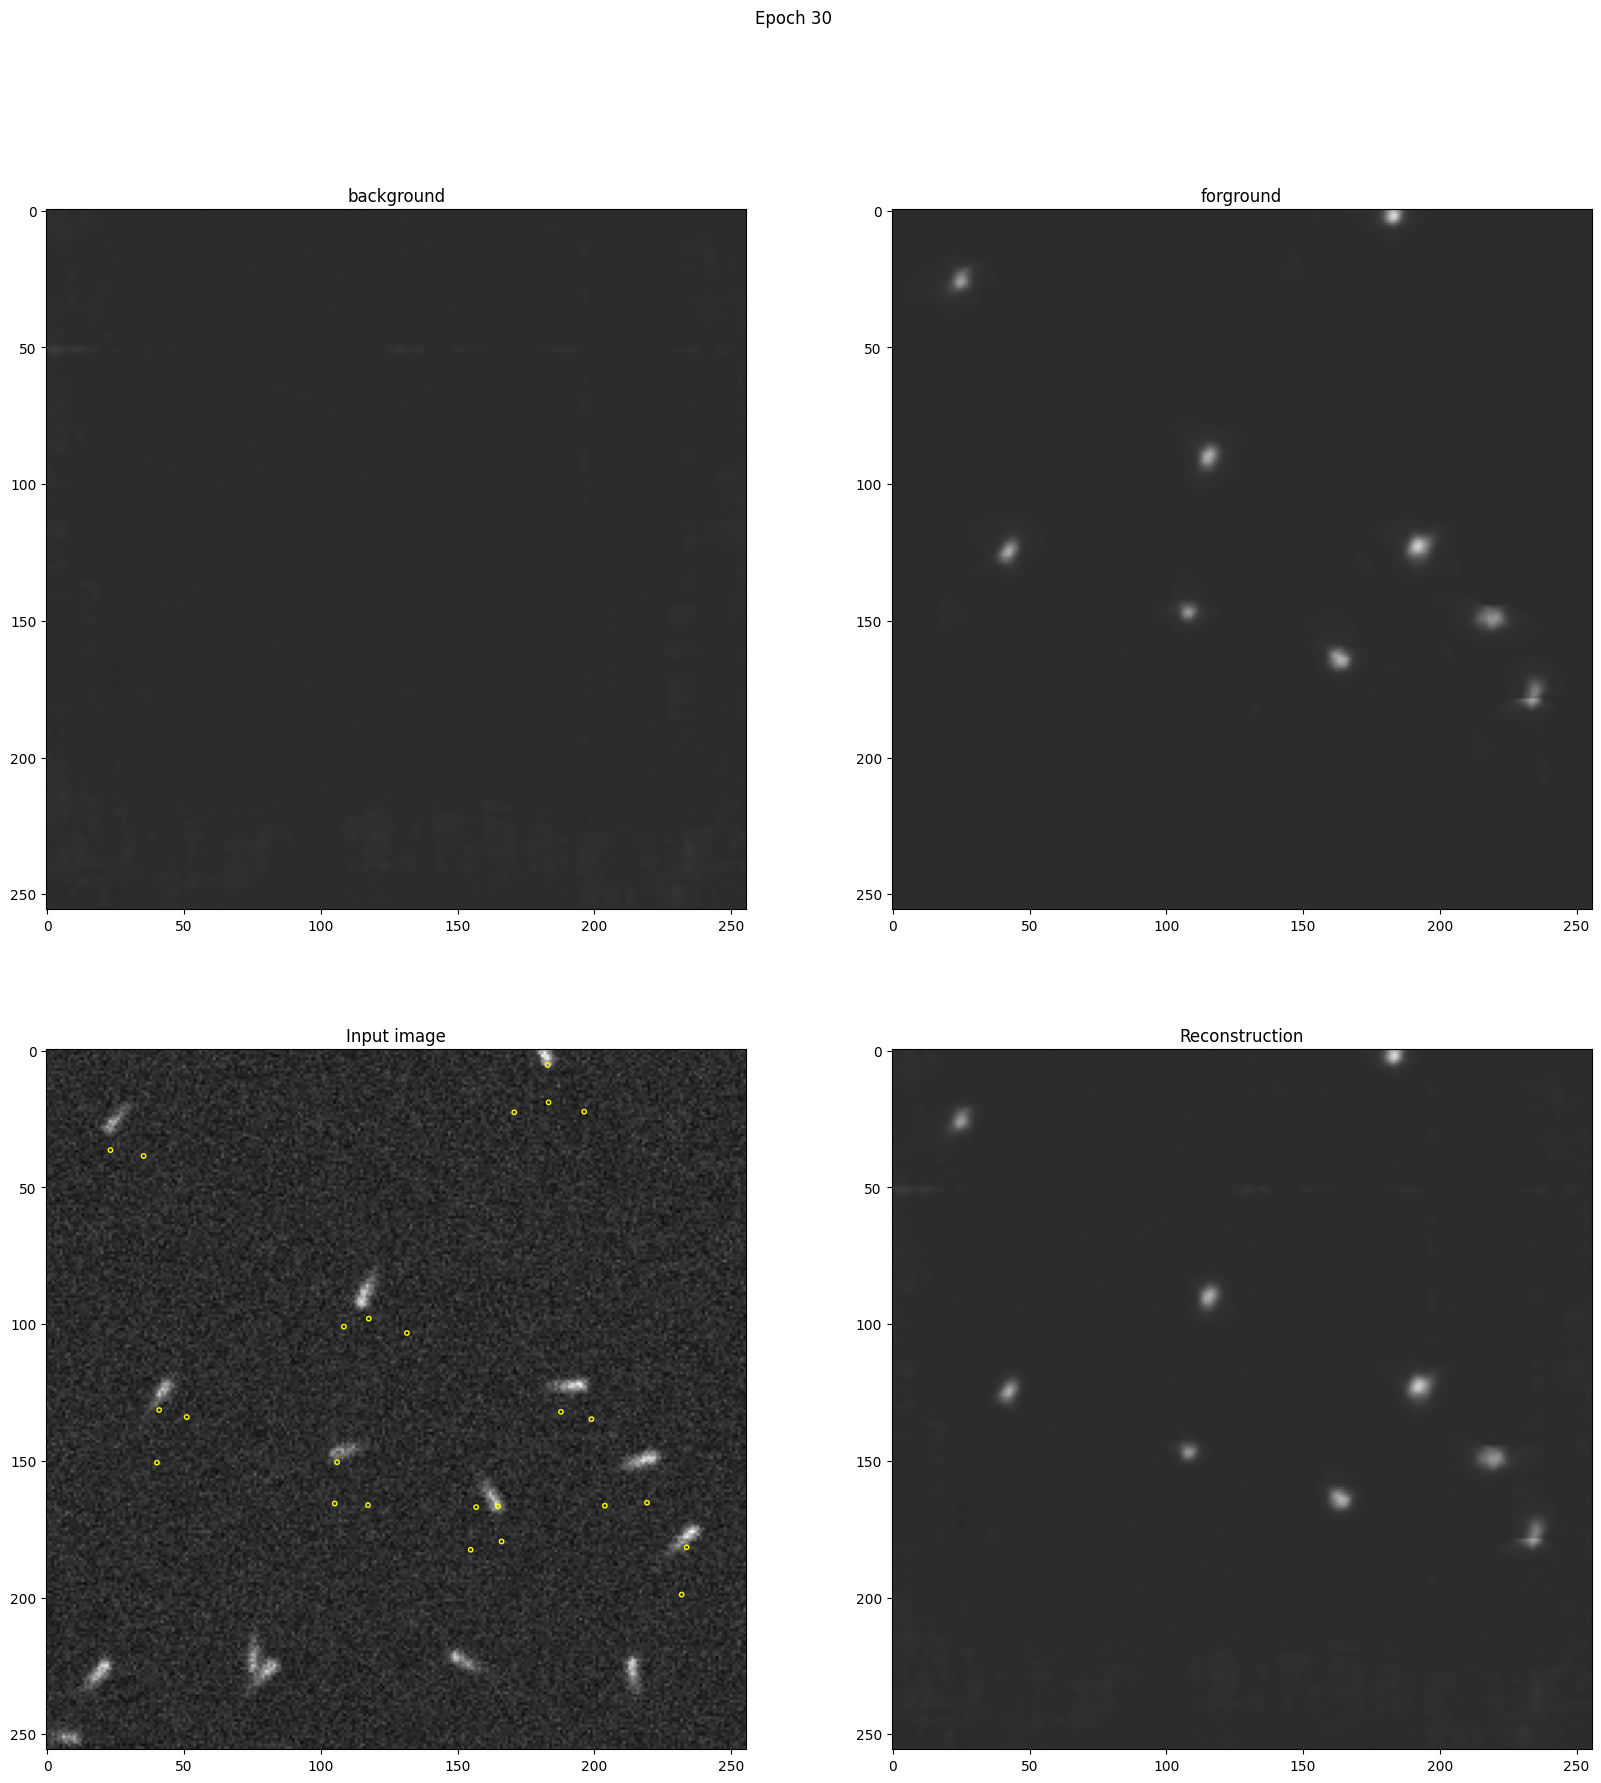

Epoch 39:  72%|███████▎  | 116/160 [00:02<00:00, 47.54it/s, v_num=2248, loss_step=0.0866, recon_loss_step=0.0866, kl_loss_step=353.0, kl_for_step=307.0, kl_back_step=46.40, loss_epoch=0.0876, recon_loss_epoch=0.0876, kl_loss_epoch=355.0, kl_for_epoch=314.0, kl_back_epoch=41.40]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

...........
{'x': [5.0763984], 'y': [60.228336], 'code': [-1], 'start': 0, 'end': 0}
{'x': [12.99966], 'y': [59.72229], 'code': [-1], 'start': 0, 'end': 0}
{'x': [5.2934046, 43.892582], 'y': [212.60703, 204.02202], 'code': [-1, -1], 'start': 0, 'end': 1}
{'x': [219.99524, 212.99773], 'y': [99.27448, 122.89208], 'code': [-1, -1], 'start': 0, 'end': 1}
{'x': [252.74313, 253.19745], 'y': [66.89093, 61.391724], 'code': [-1, -1], 'start': 2, 'end': 3}
{'x': [107.24016, 109.592255, 114.05005, 117.48622], 'y': [246.23343, 246.85077, 251.5361, 252.28157], 'code': [-1, -1, -1, -1], 'start': 0, 'end': 3}
{'x': [242.8895, 251.27777, 252.20248, 197.89359], 'y': [178.13475, 173.21074, 173.21422, 220.33112], 'code': [-1, -1, -1, -1], 'start': 0, 'end': 3}
{'x': [13.599028, 13.292796, 6.274909, 3.5979033], 'y': [244.6062, 244.23329, 245.21802, 245.20958], 'code': [-1, -1, -1, -1], 'start': 0, 'end': 3}
{'x': [197.96188, 197.47406], 'y': [226.51147, 219.92484], 'code': [-1, -1], 'start': 3, 'end': 4}


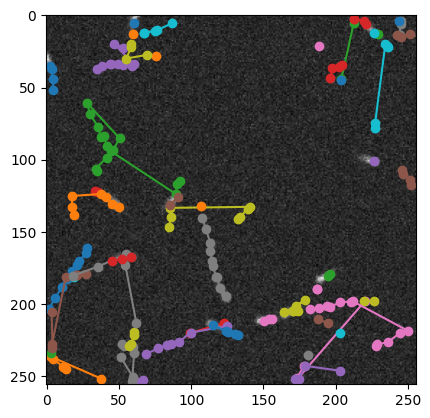

In [13]:
seq = test[0]

tra_list = model.extract_obj_and_tra(seq, 4, presence_floor=0.25, tra_floor=0.0)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

In [23]:
importlib.reload(utils_single)

utils_single.run_test(
    training_images,
    model,
    combine_radius=2,
    plot_num=None,
    num_entities=25,
    pres_floor=0.25,
    )

/workspace/aa-attention/objVAE/objVAE/single/utils_single.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


In [13]:
torch.save(model.state_dict(), "../state_dicts/model-microtubuler-256px-bad.pth")